**Non-robust Google Coab Scaffolding to load and call the combined-transformer code - needs more exit codes**

# Google Colab Scaffolding Documentation

## Overview
This notebook sets up and executes the time series forecasting application in Google Colab. It handles environment setup, module importing, and execution of the main forecasting code.

## Key Components

1. **Environment Setup**: Installs required Python libraries and checks GPU availability.

2. **Configuration**: Sets variables for directories, file names, version number, and batch size.

3. **Directory Navigation**: Ensures the notebook operates in the correct directory.

4. **File Check**: Verifies the existence of the main Python file.

5. **Execution Function**: `invoke_ViT_TS_args()`
   - Imports the main module
   - Sets up command-line arguments
   - Executes the main forecasting function

6. **Execution Trigger**: Calls the execution function if `parse_args` is True.

## Parameters Passed to main()
The `invoke_ViT_TS_args` function passes the following parameters to the `main()` function:

- `batch_size`: Integer value for the batch size (default is 34).
- `version_num`: String representing the version number (e.g., 'v35').
- `args`: An argparse.Namespace object containing:
  - `ticker`: Stock ticker symbol (default is 'AAPL').
  - `start_date`: Start date for data (default is '2020-01-01').
  - `end_date`: End date for data (default is '2023-12-31').
  - `batch_size`: Same as the `batch_size` parameter above.

## Usage
- Run cells sequentially from top to bottom.
- The scaffolding will set up the environment, load the forecasting module, and execute it.

## Customization
- Modify `version_number`, `base_dir`, `fnm`, and `default_batch_sz` as needed.
- Adjust arguments in `parser.parse_args()` within `invoke_ViT_TS_args()` for different stocks or date ranges.

## Troubleshooting
- Check `base_dir` and `fnm` if the main file is not found.
- Ensure Colab runtime is set to use GPU for GPU-related issues.
- Verify all required libraries are installed if import errors occur.

---

*Note: This scaffolding is specific to Google Colab and may need modifications for different environments.*


In [1]:
# setup the environment
! pip install yfinance numpy pandas matplotlib scikit-learn pyts torch einops vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 3.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [2]:
%matplotlib inline

In [3]:
!nvidia-smi

Wed Aug 21 03:05:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   53C    P8              13W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# set some variables + make sure to use GPU
root_dir = "/content/" #root dir that coalb uses
repo_git = "https://github.com/ArindamBanerji/Time-Series.git" # git repository
local_repo = "./Time-Series" # local directory base for repo
version_number = 'v36' # use a output version number
base_dir = "/content/Time-Series/Combined-Transformers/v3/" # local directory for execution
fnm = "combined_forecasting_coordinator.py" # name of python file from repo
default_batch_sz = 32 # set batch size - not being used
parse_args = True # not needed but code allows simpl invocation

In [5]:
# go to the root directory - helps for the git pulls
import os
os.chdir(root_dir)

In [6]:
# idempotent git pull
! (test -d $local_repo && git -C $local_repo pull --rebase) || git clone $repo_git

Cloning into 'Time-Series'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 68 (delta 16), reused 59 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 637.55 KiB | 23.61 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [7]:
# change directory into the local repo
import os

cwd = os.getcwd()
if (os.path.samefile(cwd, base_dir) == False) :
    os.chdir(base_dir)

In [8]:
#basic test to make sure that the file exists - should probably exit code
! (test -f "$fnm" && echo "file-exists") || echo "file-not-exists"

file-exists


In [9]:
# Option #2: dynamic import and call the main entry point.- do arg parse
import sys
import os
import importlib
import traceback  # Import traceback for error handling
import argparse  # Import argparse for command-line argument parsing

# does the heavy lifting of the call to vision-transformer code
def invoke_ViT_TS_args (default_batch_sz, base_dir, fnm, version_num) :

    print ("batch_sz", default_batch_sz)

    # check for fike path
    file_exists = os.path.exists(os.path.join(base_dir, fnm ))


    if not file_exists:
        print(f"Error: File for time series forecasting not found in {base_dir}")
    else:
        # Append the directory to Python's search path
        sys.path.append(base_dir)
        # get the module name
        module_name = fnm.replace('.py', '')

        # Attempt to import the module directly (no relative import)
        try:
            module = importlib.import_module(module_name)

            # Define command-line arguments
            parser = argparse.ArgumentParser()
            parser.add_argument('--ticker', type=str, required=True, help='Stock ticker symbol')
            parser.add_argument('--start_date', type=str, required=True, help='Start date for data')
            parser.add_argument('--end_date', type=str, required=True, help='End date for data')
            # Add an argument for batch size
            parser.add_argument('--batch_size', type=int, default=default_batch_sz, help='Batch size for training')
            args = parser.parse_args(['--ticker', 'AAPL', '--start_date', '2020-01-01', '--end_date', '2023-12-31', f'--batch_size={default_batch_sz}'])

            # Call the main function from the imported module, passing the batch size from args
            module.main(batch_size=args.batch_size, version_num=version_number, args=args)

        except SystemExit as e:
            print(f"The 'main' function exited with code: {e.code}")
            # Print the traceback to see what led to the SystemExit
            traceback.print_exc()

batch_sz 32
Fetching stock data for AAPL...


[*********************100%%**********************]  1 of 1 completed


Preparing data for Transformer model...
Preparing data for Vision Transformer model...
Preparing data for Simple LSTM model...
Training and evaluating Transformer model...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [10/100], Loss: 0.0294
Epoch [20/100], Loss: 0.0296
Epoch [30/100], Loss: 0.0194
Epoch [40/100], Loss: 0.0177
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0148
Epoch [70/100], Loss: 0.0123
Epoch [80/100], Loss: 0.0089
Epoch [90/100], Loss: 0.0079
Epoch [100/100], Loss: 0.0070
Training and evaluating Vision Transformer model...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 1, Epoch [10/300], Train Loss: 0.1229, Val Loss: 0.1203
Fold 1, Epoch [20/300], Train Loss: 0.1075, Val Loss: 0.1161
Fold 1, Epoch [30/300], Train Loss: 0.0928, Val Loss: 0.1069
Fold 1, Epoch [40/300], Train Loss: 0.0881, Val Loss: 0.1060
Fold 1, Epoch [50/300], Train Loss: 0.0863, Val Loss: 0.1016
Fold 1, Epoch [60/300], Train Loss: 0.0721, Val Loss: 0.0910
Fold 1, Epoch [70/300], Train Loss: 0.0634, Val Loss: 0.0665
Fold 1, Epoch [80/300], Train Loss: 0.0620, Val Loss: 0.0606
Fold 1, Epoch [90/300], Train Loss: 0.0557, Val Loss: 0.0643
Fold 1, Epoch [100/300], Train Loss: 0.0369, Val Loss: 0.0504
Fold 1, Epoch [110/300], Train Loss: 0.0288, Val Loss: 0.0483
Fold 1, Epoch [120/300], Train Loss: 0.0361, Val Loss: 0.0466
Fold 1, Epoch [130/300], Train Loss: 0.0289, Val Loss: 0.0585
Fold 1, Epoch [140/300], Train Loss: 0.0226, Val Loss: 0.0490
Early stopping at epoch 142
Fold 2, Epoch [10/300], Train Loss: 0.1234, Val Loss: 0.1257
Fold 2, Epoch [20/300], Train Loss: 0.1030, Val Loss

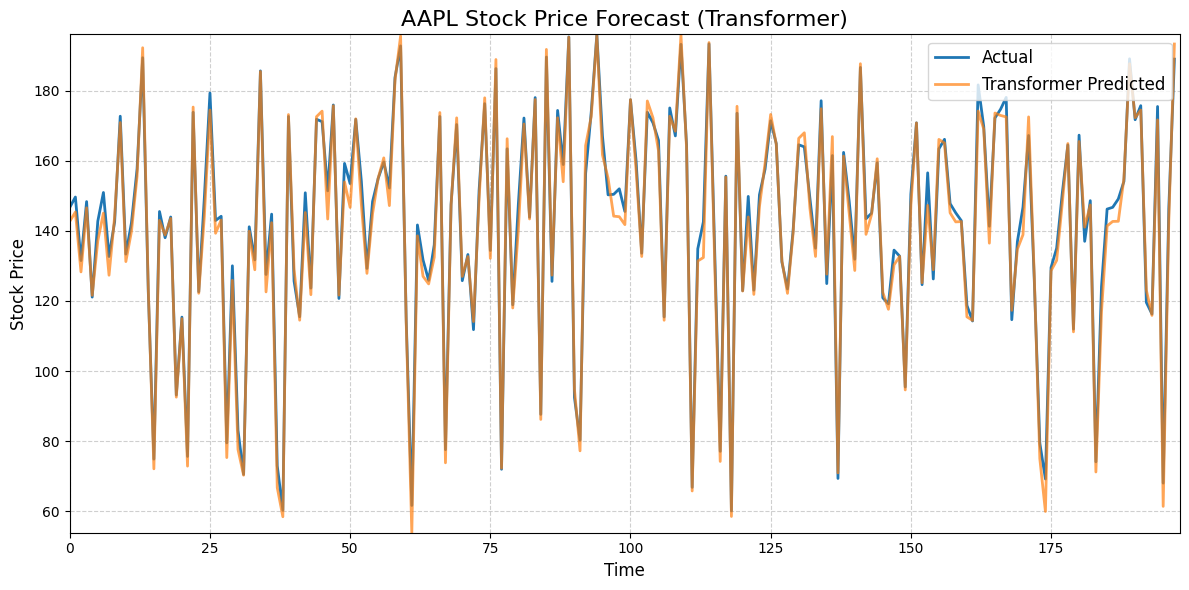

Plot saved as 'plots/v36_AAPL_forecast_transformer.png'


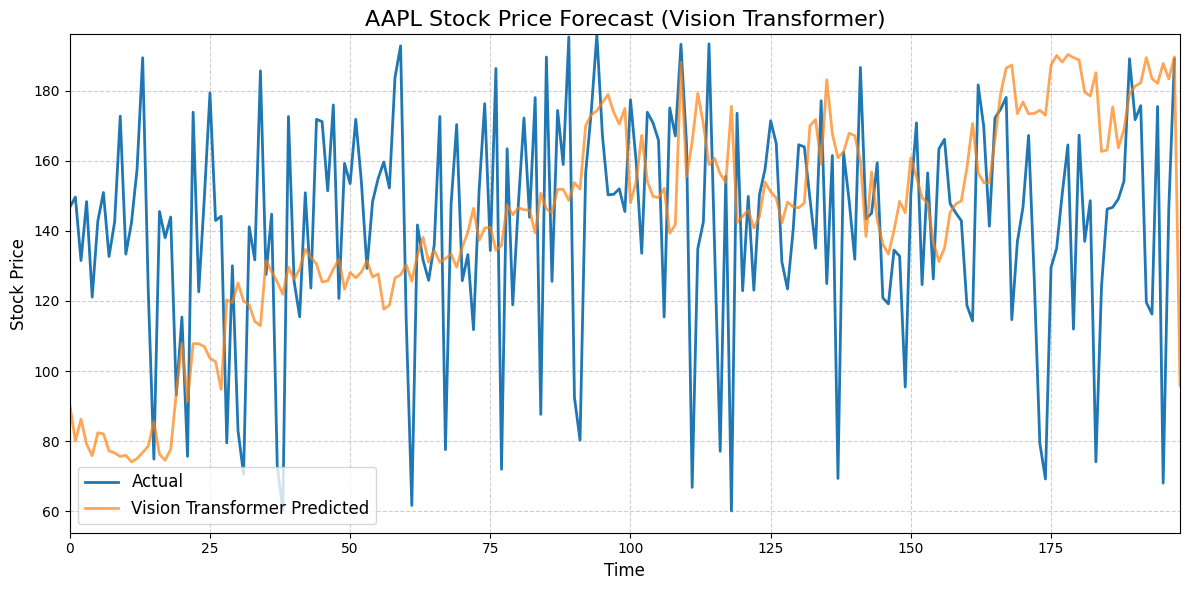

Plot saved as 'plots/v36_AAPL_forecast_vision_transformer.png'


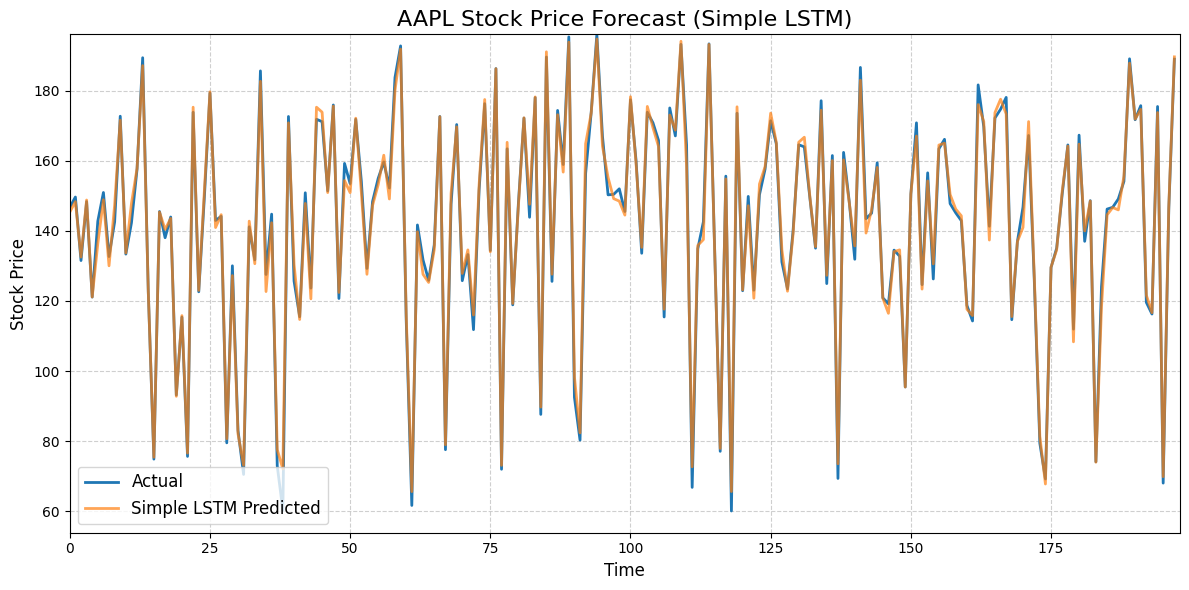

Plot saved as 'plots/v36_AAPL_forecast_simple_lstm.png'
Saving combined metrics...
Combined metrics saved to 'metrics/v36_AAPL_2020-01-01_2023-12-31_combined_metrics.csv'
Generating combined summary...

Stock Price Forecast Summary for AAPL
Version: v36
Period: 2020-01-01 to 2023-12-31

Transformer Model Metrics:
MSE:  11.8297
RMSE: 3.4394
MAE:  2.6844
R2:   0.9880
MAPE: 2.0664%

Vision Transformer Model Metrics:
MSE:  112.1335
RMSE: 10.5893
MAE:  7.7738
R2:   0.8931
MAPE: 6.3428%

Simple LSTM Model Metrics:
MSE:  6.8937
RMSE: 2.6256
MAE:  1.9687
R2:   0.9930
MAPE: 1.5708%

Comparative Summary:
- The Simple LSTM model explains the highest variance at 99.30%.
- The Simple LSTM model has the lowest average prediction error at $2.63 (RMSE).
- The Simple LSTM model's predictions are the most accurate with an average error of 1.57%.
- Overall, the Simple LSTM model performs best in terms of R2 score and prediction accuracy.

Transformer vs Vision Transformer Comparison:
- R2 Score: The Tran

In [10]:
# based on th parse_arg flag - do the call.
if parse_args :
      invoke_ViT_TS_args (default_batch_sz, base_dir, fnm, version_number)